In [1]:
import pandas as pd
import numpy as np

### 数据预处理

In [2]:
np.random.seed(0)
## pd转为array，标准化，将训练数据划分为开发集和训练集
## 数据格式转化
X_train_fpath = '/Users/shuiguangshan/Mydocument/Grade 1 master/06 ML/02 CodeEveryday/02-classification/X_train.csv'
Y_train_fpath = '/Users/shuiguangshan/Mydocument/Grade 1 master/06 ML/02 CodeEveryday/02-classification/Y_train.csv'
X_test_fpath = '/Users/shuiguangshan/Mydocument/Grade 1 master/06 ML/02 CodeEveryday/02-classification/X_test.csv'
output_fpath = '/Users/shuiguangshan/Mydocument/Grade 1 master/06 ML/02 CodeEveryday/02-classification/output_{}.csv'

# Parse csv files to numpy array
# >>> y[1]
# 2
# >>> y[1:2]
# array([2])
# 这就是为什么 X_train 是 n * m，Y_train是 1 * n

with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float) # array([[1,2], [2,3]...])
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)  # array([1,0,0,1,...])
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

## normalize data
def _normalize(X, train_set = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of x 
    # Arguments:
    #    X: data to be processed
    #    train_set: 'True' when processing training data, 'False' for testing data
    #    specified_column: indexs of the columns that will be normalized. If 'None', all columns will
    #          be normalized
    #    X_mean: mean value of training data, used when train_set = 'False'
    #    X_std: just like X_mean
    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train_set:
        X_mean = np.mean(X[:, specified_column], axis = 0).reshape(1, -1)
        X_std = np.std(X[:, specified_column], axis = 0).reshape(1, -1)
    
    #X[:, specified_column] = np.true_divide(X[:, specified_column] - X_mean,  X_std) 不能用这个 方差为0或NaN会报错
    X[:, specified_column] = (X[:, specified_column] - X_mean) / ( X_std + 1e-8)
    
    return X, X_mean, X_std

## 将训练数据划分为训练集和开发集
def _train_dev_split(X, Y, dev_ratio = 0.25):
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# 标准化
X_train, X_mean, X_std = _normalize(X_train, train_set = True)
X_test, _, _ = _normalize(X_test, train_set = False, X_mean = X_mean, X_std = X_std)

# 划分数据集（训练集和开发集）
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]

print('Size of training set:{}'.format(train_size))
print('Size of development set:{}'.format(dev_size))
print('Size of test set:{}'.format(test_size))
print('Dimension of data:{}'.format(data_dim))


Size of training set:48830
Size of development set:5426
Size of test set:27622
Dimension of data:510


### 经常调用的函数

In [3]:
## 数据随机化、sigmod函数、logistics函数、预测函数、正确率函数
def _shuffle(X, Y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def _sigmod(z):
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8)) # 这里的z可以是一个向量 n * 1

def _f(X, w, b):
    return _sigmod(np.matmul(X, w) + b) ## matual()矩阵相乘 返回1 * n 的矩阵

def _predict(X, w, b):
    return np.round(_f(X, w, b)).astype(np.int)  # np.round(x, decimals = 0) 四舍五入，decimals表示几位小数

def _accuracy(Y_pred, Y_label):
    return (1 - np.mean(np.abs(Y_pred - Y_label))) # np.mean() 默认情况是对所有值求平均，aixs=0 是对列求平均，axis=1是对行求平均
    

### 梯度和损失函数计算

In [4]:
## 损失函数使用交叉熵，不用mse，具体原因见笔记
def _cross_entropy_loss(y_pred, Y_label):
    cross_entropy_loss = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy_loss

def _gradient(X, Y_label, w, b):
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1) # 这步是为啥？ # w_grad = -np.dot(x.T, pred_error) * 乘就是对应位置相乘
    # y = np.array([1,2,3])
    # X = np.array([[1,2],[3,4],[4,5]])
    # y * X.T
    # array([[ 1,  6, 12],
    #        [ 2,  8, 15]])
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad

### 模型训练

In [5]:
# 初始化权重和偏移量
w = np.zeros((data_dim,))
b = np.zeros((1,))

# 训练的参数
max_iter = 10
batch_size = 8
learning_rate = 0.2

# 记录每次迭代的损失值和准确率，以便画图
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# 记录参数更新的次数
step = 1

# 迭代训练
for epoch in range(max_iter):
    # 对数据进行洗牌
    X_train, Y_train = _shuffle(X_train, Y_train)
    
    # 小批量梯度更新 mini-batch gradient
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx * batch_size : (idx + 1) * batch_size]
        Y = Y_train[idx * batch_size : (idx + 1) * batch_size]
        
        # 计算梯度
        w_grad, b_grad = _gradient(X, Y, w, b)
        
        # 梯度下降更新
        # 学习率随时间递减
        w -= learning_rate / np.sqrt(step) * w_grad
        b -= learning_rate / np.sqrt(step) * b_grad
        
        step += 1
    # 计算训练集、开发集的loss值和accuracy 
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    
    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development loss: {}'.format(dev_acc[-1]))

Training loss: 0.271355435246406
Development loss: 0.2896359675026286
Training accuracy: 0.8836166291214418
Development loss: 0.8733873940287504


### 画损失函数图和正确率图

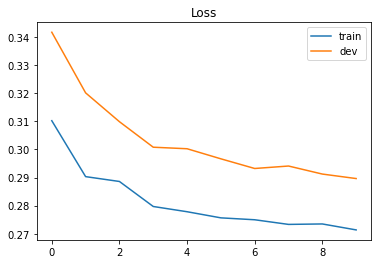

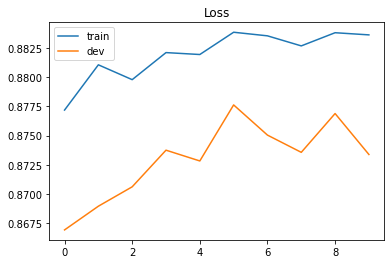

In [6]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('loss.png')
plt.show()

# accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('acc.png')
plt.show()

### 预测测试集

In [9]:
# predict testing labels
predictions = _predict(X_test, w, b)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]  # https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',') # 读取第一行特征名称
features = np.array(content)
for i in ind[0: 10]: # 取权重绝对值最大的10个特征
    print(features[i], w[i])

 Not in universe -4.031960278019252
 Spouse of householder -1.6254039587051405
 Other Rel <18 never married RP of subfamily -1.4195759775765389
 Child 18+ ever marr Not in a subfamily -1.2958572076664747
 Unemployed full-time 1.1712558285885908
 Other Rel <18 ever marr RP of subfamily -1.1677918072962363
 Italy -1.0934581438006181
 Vietnam -1.063036563314642
num persons worked for employer 0.9389922773566483
 1 0.8226614922117192


### 用概率生成模型预测

In [11]:
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float) # array([[1,2], [2,3]...])
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)  # array([1,0,0,1,...])
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

X_train, X_mean, X_std = _normalize(X_train, train_set = True)
X_test, _, _ = _normalize(X_test, train_set=False, specified_column = None, X_mean = X_mean, X_std = X_std)

In [12]:
# 计算平均值和协方差
X_train_0 = np.array([x for x, y in zip(X_train, Y_train) if y == 0])
X_train_1 = np.array([x for x, y in zip(X_train, Y_train) if y == 1])

mean_0 = np.mean(X_train_0, axis = 0)
mean_1 = np.mean(X_train_1, axis = 0)

cov_0 = np.zeros((data_dim, data_dim))
cov_1 = np.zeros((data_dim, data_dim))

for x in X_train_0:
    cov_0 += np.dot(np.transpose([x - mean_0]), [x - mean_0]) / X_train_0.shape[0]
for x in X_train_1:
    cov_1 += np.dot(np.transpose([x - mean_1]), [x - mean_1]) / X_train_1.shape[0]

# Shared covariance is taken as a weighted average of individual in-class covariance.    
cov = (cov_0 * X_train_0.shape[0] + cov_1 * X_train_1.shape[0])

### 计算权重和偏差向量

In [14]:
# 协方差的逆矩阵
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# 计算权重和偏差
w = np.dot(inv, mean_0 - mean_1)
b =  (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1))\
    + np.log(float(X_train_0.shape[0]) / X_train_1.shape[0]) 

# Compute accuracy on training set
Y_train_pred = 1 - _predict(X_train, w, b)
print('Training accuracy: {}'.format(_accuracy(Y_train_pred, Y_train)))

Training accuracy: 0.7944743438513713


In [15]:
# Predict testing labels
predictions = 1 - _predict(X_test, w, b)
with open(output_fpath.format('generative'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Retail trade 0.00015649199485778809
 34 -0.00012093782424926758
 37 -0.00010970234870910645
 Other service -0.00010110437870025635
 35 8.296966552734375e-05
 Construction -7.915496826171875e-05
 35 5.2809715270996094e-05
 Private household services -5.072355270385742e-05
 3 -4.9114227294921875e-05
 39 4.762411117553711e-05


### scikit_learn 实例

#### sklearn.linear_model.LogisticRegression

solver参数决定了我们对逻辑回归损失函数的优化方法，有四种算法可以选择，分别是：
- a) liblinear：使用了开源的liblinear库实现，内部使用了坐标轴下降法来迭代优化损失函数。
- b) lbfgs：拟牛顿法的一种，利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数。
- c) newton-cg：也是牛顿法家族的一种，利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数。
- d) sag：即随机平均梯度下降，是梯度下降法的变种，和普通梯度下降法的区别是每次迭代仅仅用一部分的样本来计算梯度，适合于样本数据多的时候。

In [3]:
from math import exp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

In [4]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
data = np.array(df.iloc[:100, [0,1,-1]])
X, y = data[:,:2], data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

clf = LogisticRegression(max_iter = 200)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [5]:
clf.predict(X_test)

array([0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.])

In [6]:
clf.score(X_test, y_test)

0.9666666666666667

In [7]:
print(clf.coef_, clf.intercept_)

[[ 2.55188756 -2.88490912]] [-4.83721464]


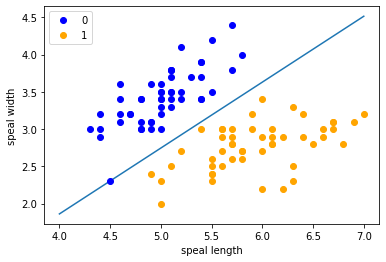

In [10]:
x_points = np.arange(4, 8)
y_ = -(clf.coef_[0][0] * x_points + clf.intercept_) / clf.coef_[0][1]
plt.plot(x_points, y_)

plt.plot(X[:50, 0], X[:50, 1], 'bo', color = 'blue', label = '0')
plt.plot(X[50:, 0], X[50:, 1], 'bo', color = 'orange', label = '1')
plt.xlabel('speal length')
plt.ylabel('speal width')
plt.legend()